<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/NLP/%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%EB%A5%BC%20%EC%9C%84%ED%95%9C%20%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8/2%EC%9E%A5_BERT_%EB%AA%A8%EB%8D%B8_%EB%AF%B8%EC%84%B8%EC%A1%B0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. GPU 활성화

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':

  raise SystemError('GPU device not found')

print('Found GPU at : {}'.format(device_name))

Found GPU at : /device:GPU:0


# BERT용 HuggingFace PyTorch 인터페이스 설치

In [2]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 16.2 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 6.6 MB 61.5 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 


# 모듈 불러오기

In [4]:
import torch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

# CUDA를 Torch용 디바이스로 지정하기

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

# 데이터셋 불러오기

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
df = pd.read_csv('/content/drive/MyDrive/자연어 처리를 위한 트랜스포머/in_domain_train.tsv',
                 delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

df.shape

(8551, 4)

In [14]:
df.sample(10)

,sentence_source,label,label_notes,sentence
4258,ks08,1,NaN,john seems to fix the computer .
4867,ks08,0,*,they investigated .
5362,b_73,1,NaN,he offers more than we had hoped for .
275,cj99,0,*,the more time that every senator spends with l...
2860,l-93,0,*,carol carved at the stone .
7117,sgww85,1,NaN,we talked about mr. colson and that he had wor...
7222,sks13,1,NaN,what henri wants is the book which is on the t...
7364,sks13,1,NaN,i saw john with a telescope .
456,bc01,1,NaN,there are n't many linguistics students here .
6777,m_02,0,*,because never had sir thomas been so offended ...


# 문장 및 레이블 목록 생성, BERT 토큰 추가

In [16]:
sentences = df.sentence.values

In [18]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]
labels = df.label.values

# BERT 토크나이저 활성화

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
print('Tokenize the frist sentence:')
print(tokenized_texts[0])

Tokenize the frist sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


# 데이터 처리

In [24]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype='long',
                          truncating='post',
                          padding='post')

In [26]:
input_ids[0]

array([  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,
        4106,  1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,
        1012,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

# 어탠션 마스크 생성

In [28]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [31]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# 훈련 및 검증 데이터 분리

In [33]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                                                    random_state=2022,
                                                                                    test_size=0.1)

In [34]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, 
                                                       random_state=2022,
                                                       test_size=0.1)

# Torch 텐서로 데이터 변환

In [36]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended

# 뱃치 크기 선택 및 iterator 생성

In [38]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BERT 모델 설정

In [40]:
import transformers
from transformers import BertModel, BertConfig

config = BertConfig()

model = BertModel(config)

In [41]:
config = model.config
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



# Hugging Face Bert uncased 베이스 모델 불러오기

In [43]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Optimizer 그룹 파라미터

In [45]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
                                {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate':0.1},
                                {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate':0.0}
                                ]

# 훈련 루프용 하이퍼파라미터

In [59]:
epochs = 4

In [60]:
optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [61]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [62]:
total_steps = len(train_dataloader) * epochs

In [63]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 훈련 루프

In [64]:
t = [] 

train_loss_set = []


for _ in trange(epochs, desc="Epoch"):
  
  model.train()
  
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()

    scheduler.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5306395115446748


Epoch:  25%|██▌       | 1/4 [00:54<02:44, 54.72s/it]

Validation Accuracy: 0.8163580246913581
Train loss: 0.3296408672426746


Epoch:  50%|█████     | 2/4 [01:46<01:46, 53.16s/it]

Validation Accuracy: 0.8387345679012346
Train loss: 0.20362399388645694


Epoch:  75%|███████▌  | 3/4 [02:38<00:52, 52.58s/it]

Validation Accuracy: 0.8410493827160493
Train loss: 0.13608497256776356


Epoch: 100%|██████████| 4/4 [03:30<00:00, 52.68s/it]

Validation Accuracy: 0.8491512345679012


# 훈련 평가

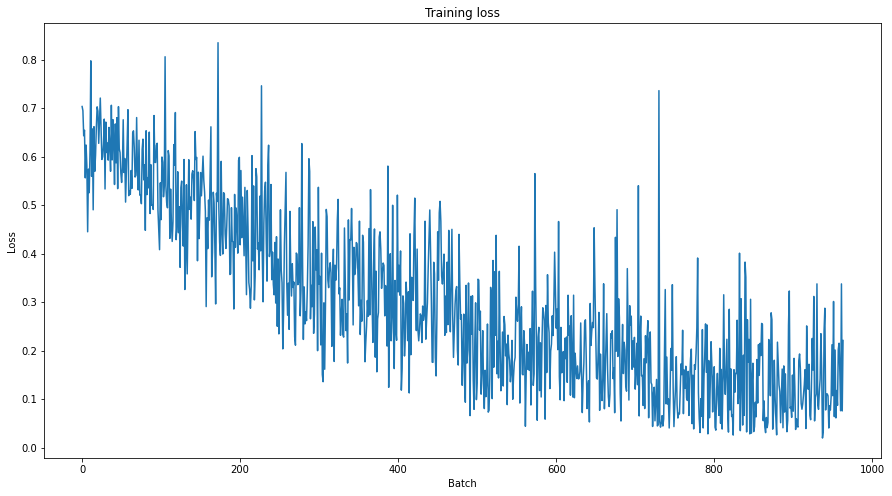

In [65]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# 미사용 데이터셋에 의한 예측 및 평가

In [66]:
df = pd.read_csv('/content/drive/MyDrive/자연어 처리를 위한 트랜스포머/out_of_domain_dev.tsv',
                 delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [72]:
sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [73]:
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)


In [74]:
logits = logits['logits'].detach().cpu().numpy()
label_ids = b_labels.to('cpu').numpy()

In [88]:
model.eval()

predictions , true_labels = [], []
 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

# Matthews 상관 계수에 의한 평가

In [89]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

# 개별 뱃치 점수

In [90]:
matthews_set

[0.049286405809014416,
 -0.17407765595569785,
 0.4732058754737091,
 0.41179801403140964,
 0.32328707534629597,
 0.7410010097502685,
 0.5204358386562267,
 0.0,
 0.8320502943378436,
 0.8246211251235321,
 0.7624437362098716,
 0.647150228929434,
 0.8150678894028793,
 0.7141684885491869,
 0.1794871794871795,
 0.6476427756840265,
 -0.3333333333333333]

# 전체 데이터셋에 대한 Matthews 평가

In [91]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5399354485268115